In [1]:
%matplotlib inline
from copy import deepcopy as copy
from itertools import product as c_product
import os

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn import linear_model
from scipy import stats

from aux import nansem
from disp import set_font_size, get_line
from lin_fit import fit_h, make_extended_predictor_matrix

#EXPT = 'CL_360_LOWFLOW_ACV'; T_WDW_PST = [-10., 0.]; LABEL = 'BEFORE'
EXPT = 'CL_360_LOWFLOW_ACV'; T_WDW_PST = [0., 10.]; LABEL = 'DURING'
#EXPT = 'CL_180_HighFlow_ACV'; T_WDW_PST = [-10., 0.]; LABEL = 'BEFORE'
#EXPT = 'CL_180_HighFlow_ACV'; T_WDW_PST = [0., 10.]; LABEL = 'DURING'
#EXPT = 'CL_360_LOWFLOW_Fed'; T_WDW_PST = [-10., 0.]; LABEL = 'BEFORE'
#EXPT = 'CL_360_LOWFLOW_Fed'; T_WDW_PST = [0., 10.]; LABEL = 'DURING'

TARGS = ['G2', 'G3', 'G4', 'G5']
SRCS = ['Odor', 'AbsHeading', 'ForVel']
NORMED_COLS = ['G2', 'G3', 'G4', 'G5']

COLORS = {
    'G2': 'b', 'G3': 'r', 'G4': 'g', 'G5': 'm',
    'Motion': (1, .5, 0), 'ForVel': 'k', 'AbsAngVel': 'y', 'AbsHeading': 'c', 
}

DT = 0.1
CTL_T_OFFSET = 0

DATA_DIR = os.path.join('data_', EXPT)
SAVE_DIR = os.path.join('data_', '_RESULTS', 'ODOR_TRIG_FILTER_MODEL')

if not os.path.exists(SAVE_DIR):
    os.makedirs(SAVE_DIR)

# Load data and normalize

In [2]:
base = 'clean.csv'
mvng = 'moving.csv'
mvng_cols = ['Start', 'Stop']
odor = 'odor_times.csv'
odor_cols = ['Odor_On', 'Odor_Off', 'Include']

trials = []
pulses = []
data_u = {}  # unnormalized data
data_n = {}  # normalized data
d_mvng = {}  # dfs of moving times
d_odor = {}  # dfs of odor times

for fly in os.listdir(DATA_DIR):
    fly_path = os.path.join(DATA_DIR, fly)
    
    for trial in os.listdir(fly_path):
        trial_path = os.path.join(fly_path, trial)
        
        # load data
        data_u_ = pd.read_csv(os.path.join(trial_path, base))
        
        # store relevant columns
        try:
            data_u_ = data_u_[['Time', 'G2_avg', 'G3_avg', 'G4_avg', 'G5_avg', 'ForVel', 'AngVel', 'AbsHeading', 'Motion']]
        except:
            data_u_ = data_u_[['Time', 'G2_avg', 'G3_avg', 'G4_avg', 'G5_avg', 'ForVel', 'AngVel', 'Heading', 'Motion']]
            data_u_['AbsHeading'] = np.abs(data_u_['Heading'])
        data_u_['AbsAngVel'] = np.abs(data_u_['AngVel'])
        data_u_['AbsHeading'] = data_u_['AbsHeading']
        
        # make odor mask
        df_odor = pd.read_csv(os.path.join(trial_path, odor))
        if EXPT == 'CL_180_HighFlow_ACV':
            df_odor[odor_cols[1]] = 150
        df_odor[odor_cols[0]] += CTL_T_OFFSET
        df_odor[odor_cols[1]] += CTL_T_OFFSET
        
        odor_mask = np.zeros(len(data_u_['Time']), dtype=bool)
        starts = df_odor[odor_cols[0]]
        stops = df_odor[odor_cols[1]]
        includes = df_odor[odor_cols[2]]
        
        for ctr, (start, stop, include) in enumerate(zip(starts, stops, includes)):
            odor_mask[(start <= data_u_['Time']) & (data_u_['Time'] < stop)] = True
            # add to pulse dict
            if include:
                pulses.append(
                    {'Fly': fly, 'Trial': trial, 'Pulse': ctr, 'Start': start, 'Stop': stop, 'Include': include})
            
        data_u_['Odor'] = odor_mask.astype(float)
        
        # make moving mask
        df_mvng = pd.read_csv(os.path.join(trial_path, mvng))
        starts = df_mvng[mvng_cols[0]]
        stops = df_mvng[mvng_cols[1]]
        mvng_mask = np.zeros(len(data_u_['Time']), dtype=bool)
        
        for start, stop in zip(starts, stops):
            mvng_mask[(start <= data_u_['Time']) & (data_u_['Time'] < stop)] = True
            
        data_u_['Mvng'] = mvng_mask
        
        data_u_ = data_u_.rename(columns={'G2_avg': 'G2', 'G3_avg': 'G3', 'G4_avg': 'G4', 'G5_avg': 'G5'})
        
        # normalize data
        data_n_ = data_u_.copy()
        data_n_[NORMED_COLS] -= data_n_[NORMED_COLS].mean()
        data_n_[NORMED_COLS] /= data_n_[NORMED_COLS].std()
        
        # normalize motion, for-, and angvel to median walking speed
        median_walk_speed = np.nanmedian(data_n_['Motion'][mvng_mask])
        data_n_['Motion'] /= median_walk_speed
        data_n_['ForVel'] /= median_walk_speed
        data_n_['AngVel'] /= median_walk_speed
        data_n_['AbsAngVel'] /= median_walk_speed
        
        # store all results
        data_u[trial] = data_u_
        data_n[trial] = data_n_
        d_mvng[trial] = df_mvng
        d_odor[trial] = df_odor
        
        trials.append(trial)
        
df_pulse = pd.DataFrame(data=pulses, columns=['Fly', 'Trial', 'Pulse', 'Start', 'Stop', 'Include'])

n_fly = len(os.listdir(DATA_DIR))
n_trial = len(trials)
n_pulse = len(df_pulse)

print('{} FLIES, {} TRIALS, {} PULSES'.format(n_fly, n_trial, n_pulse))

26 FLIES, 48 TRIALS, 143 PULSES


In [3]:
for trial in trials:
    print(trial)

20180124.Fly4.3
20180124.Fly4.2
20180119.Fly10.1
20180531.Fly3.3
20180131.Fly7.3
20180131.Fly7.2
20180604.Fly8.3
20180604.Fly8.2
20180125.Fly3.3
20180125.Fly3.4
20180131.Fly9.3
20170826.Fly7.2
20170821.Fly1.1
20180604.Fly3.2
20180604.Fly3.3
20180604.Fly3.4
20180604.Fly3.1
20180530.Fly3.1
20180119.Fly7.2
20180530.Fly1.2
20180530.Fly1.1
20180530.Fly1.3
20180120.Fly1.2
20180120.Fly1.1
20180120.Fly1.3
20170826.Fly4.1
20180131.Fly1.3
20180131.Fly1.2
20180125.Fly6.1
20180131.Fly8.3
20180131.Fly8.4
20180131.Fly8.2
20180131.Fly8.1
20180119.Fly9.2
20180530.Fly5.5
20180530.Fly5.4
20180530.Fly5.2
20180530.Fly5.1
20180530.Fly5.3
20180531.Fly2.5
20170828.Fly4.3
20180201.Fly3.2
20180201.Fly3.4
20170822.Fly1.1
20170828.Fly2.2
20170828.Fly2.6
20180131.Fly4.2
20180131.Fly4.3


# Plot trial example

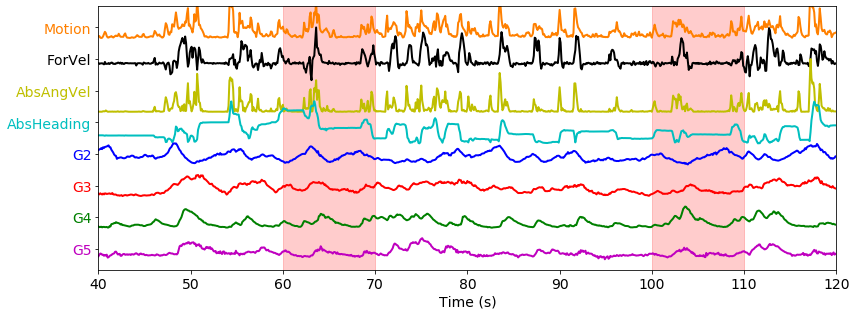

In [4]:
fig_size = (12, 4.5)
font_size = 14
trial = trials[21]
t_wdw = (40, 120)
vs = ['G2', 'G3', 'G4', 'G5']

fig, ax = plt.subplots(1, 1, figsize=fig_size, tight_layout=True)

t = data_n[trial]['Time']
t_mask = (t_wdw[0] <= t) & (t < t_wdw[1])

motion = data_n[trial]['Motion'][t_mask]
motion -= motion.min()
motion /= (.4 * motion.max())

ax.plot(t[t_mask], motion - 1.5, lw=2, c=COLORS['Motion'])

for_vel = data_n[trial]['ForVel'][t_mask]
for_vel -= for_vel.min()
for_vel /= (.4 * for_vel.max())

ax.plot(t[t_mask], for_vel - 3.5, lw=2, c=COLORS['ForVel'])

abs_ang_vel = data_n[trial]['AbsAngVel'][t_mask]
abs_ang_vel -= abs_ang_vel.min()
abs_ang_vel /= (.4 * abs_ang_vel.max())

ax.plot(t[t_mask], abs_ang_vel - 5, lw=2, c=COLORS['AbsAngVel'])

abs_heading = data_n[trial]['AbsHeading'][t_mask].copy()
abs_heading -= abs_heading.min()
abs_heading /= (.5 * abs_heading.max())

ax.plot(t[t_mask], abs_heading - 6.5, lw=2, c=COLORS['AbsHeading'])

offsets = [-1.5, -3, -4.5, -6]

for v_ctr, v in enumerate(vs):
    x = data_n[trial][v][t_mask]
    x -= x.min()
    x /= x.max()
    
    offset = -(v_ctr + 5)*1.5
    ax.plot(t[t_mask], x + offset, lw=2, c=COLORS[v])

    offsets.append(offset)
    
offsets = np.array(offsets)

df_odor = d_odor[trial]

for r_ctr, r in df_odor.iterrows():
    start = r['Odor_On']
    stop = r['Odor_Off']
    if CTL_T_OFFSET == 0:
        ax.axvspan(start, stop, color='r', alpha=0.2)
    else:
        ax.axvspan(start, stop, color='gray', alpha=0.2)
        

ax.set_xlim(t_wdw)
ax.set_ylim(-12.5, 0)
ax.set_yticks(offsets + 0.5)
ax.set_yticklabels(['Motion', 'ForVel', 'AbsAngVel', 'AbsHeading'] + vs)

for y_tick, v in zip(ax.get_yticklabels(), ['Motion', 'ForVel', 'AbsAngVel', 'AbsHeading'] + vs):
    y_tick.set_color(COLORS[v])

ax.set_xlabel('Time (s)')

set_font_size(ax, font_size)

# Peristimulus responses

/home/z051m/miniconda3/envs/sci/lib/python3.6/site-packages/ipykernel_launcher.py:16: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  app.launch_new_instance()


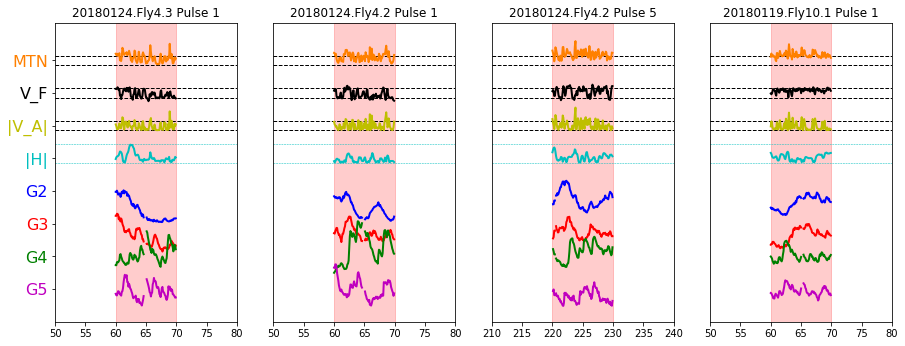

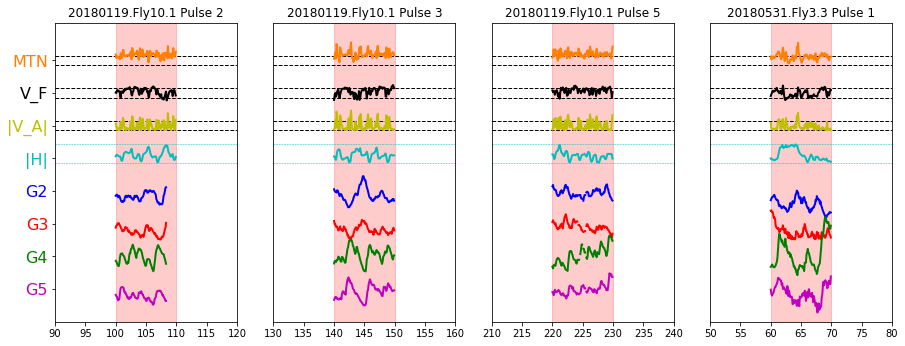

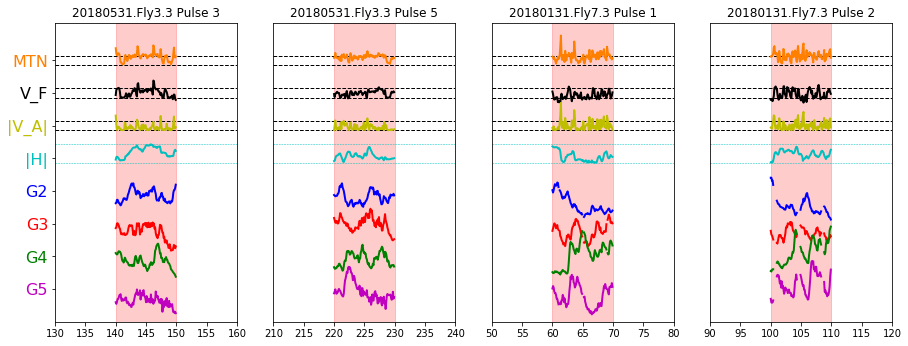

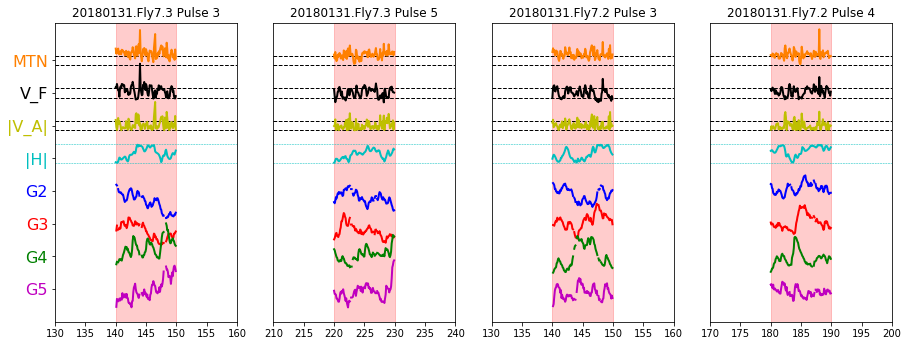

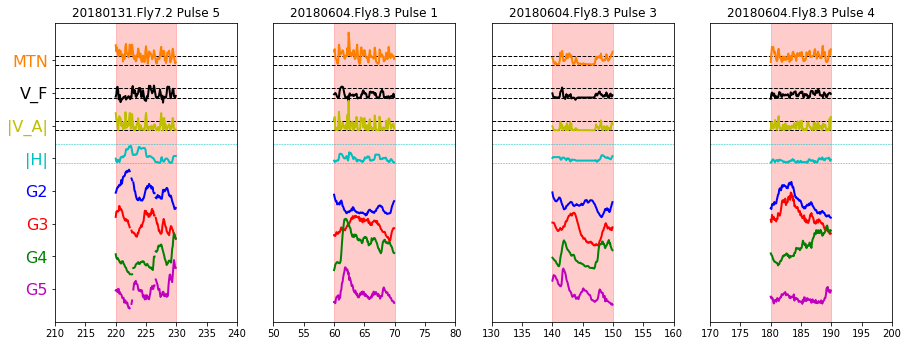

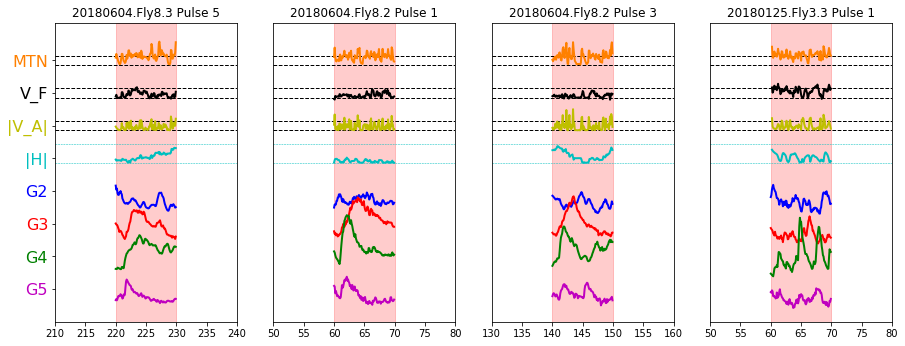

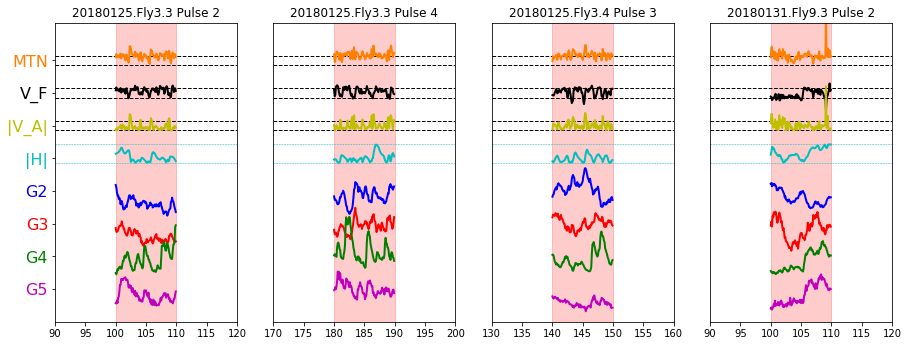

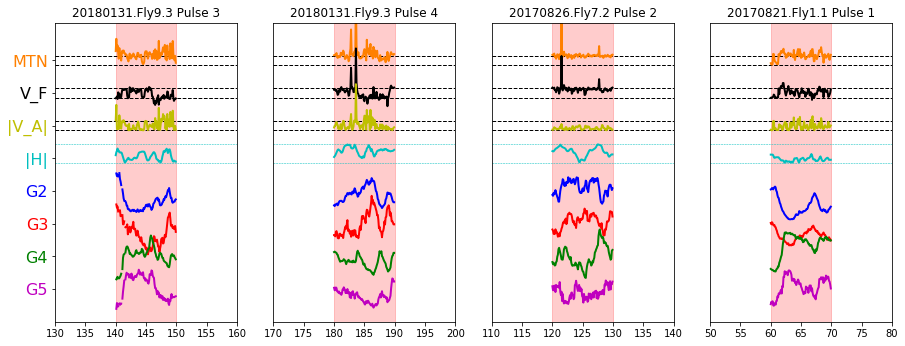

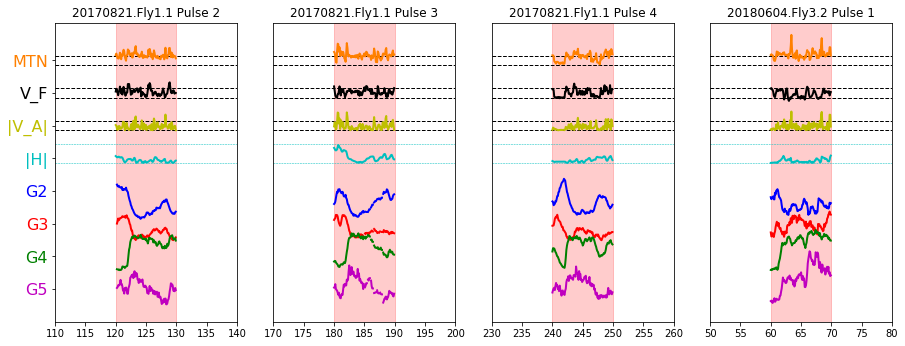

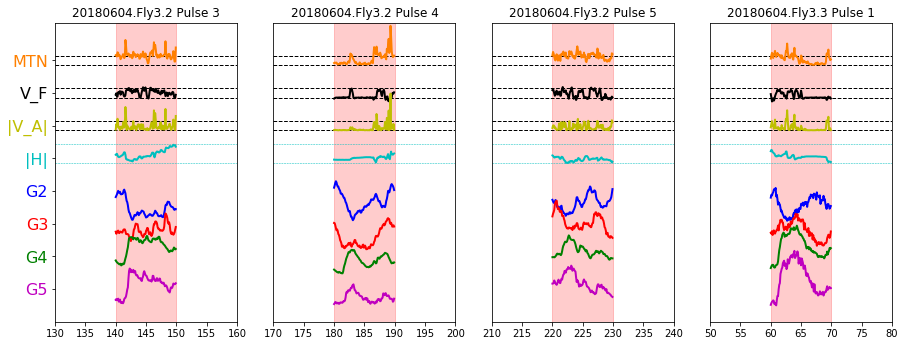

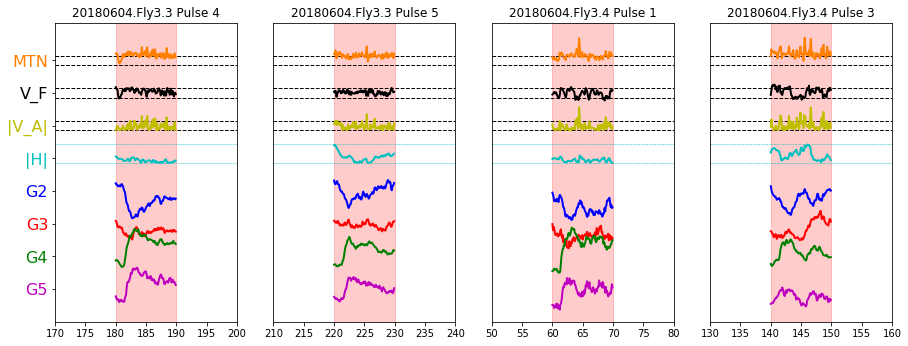

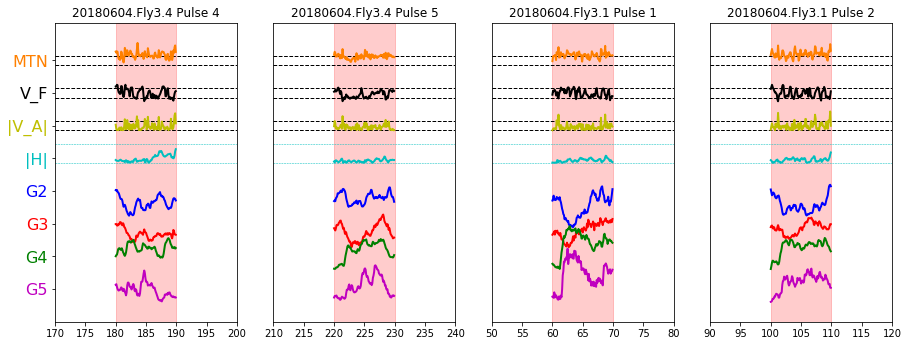

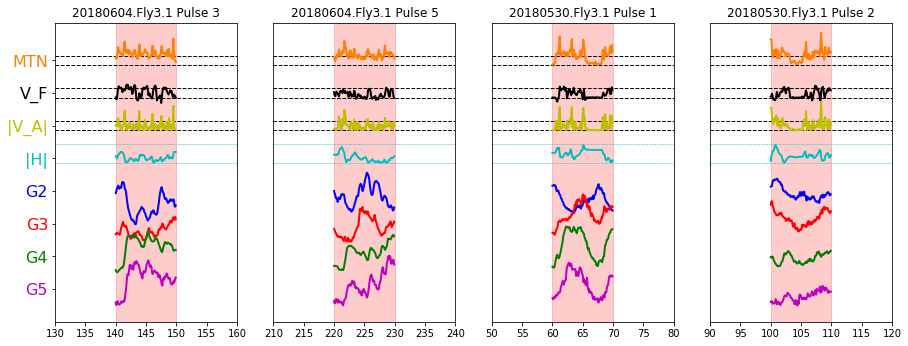

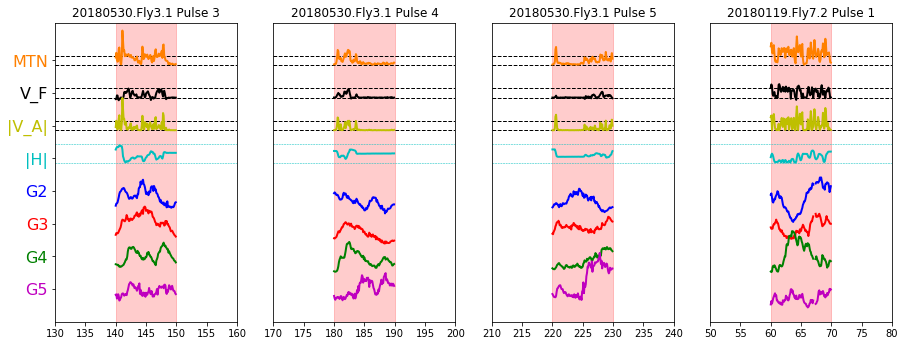

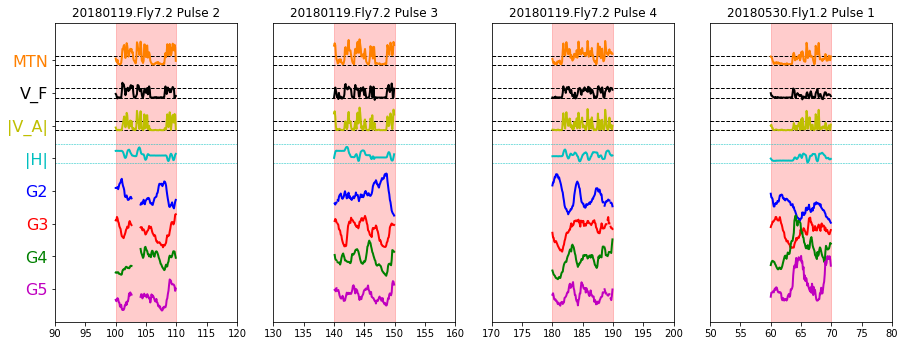

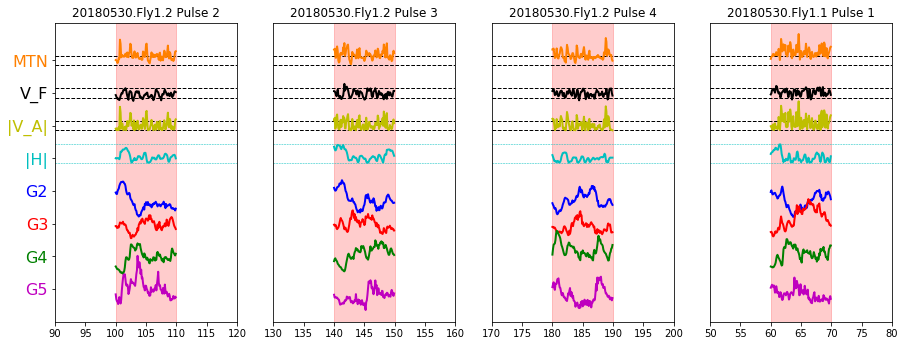

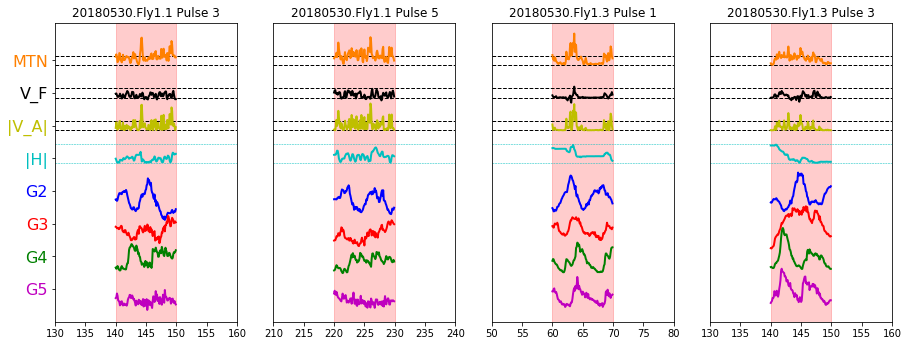

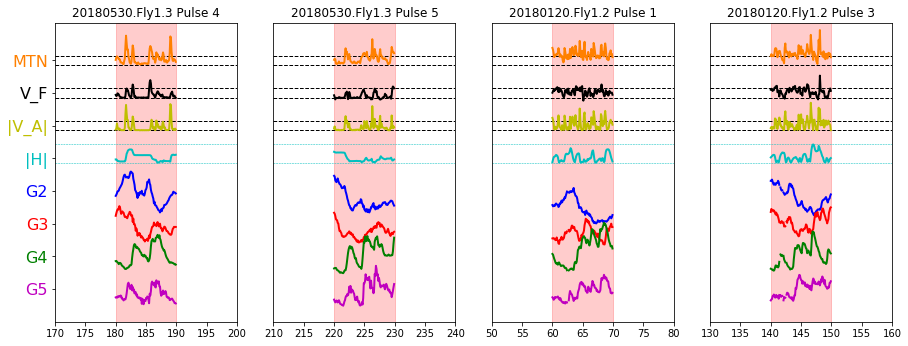

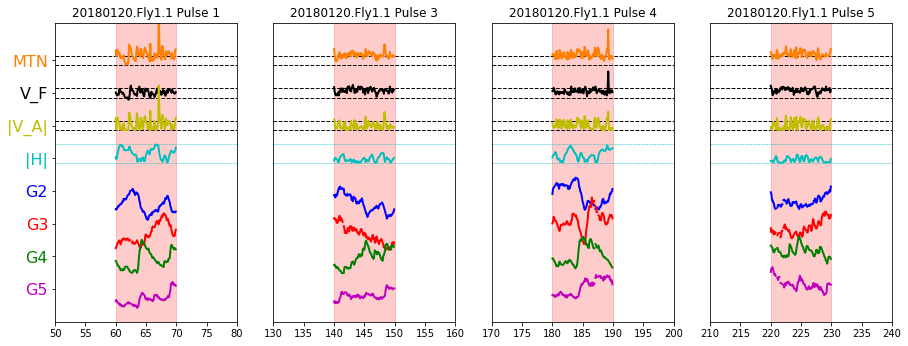

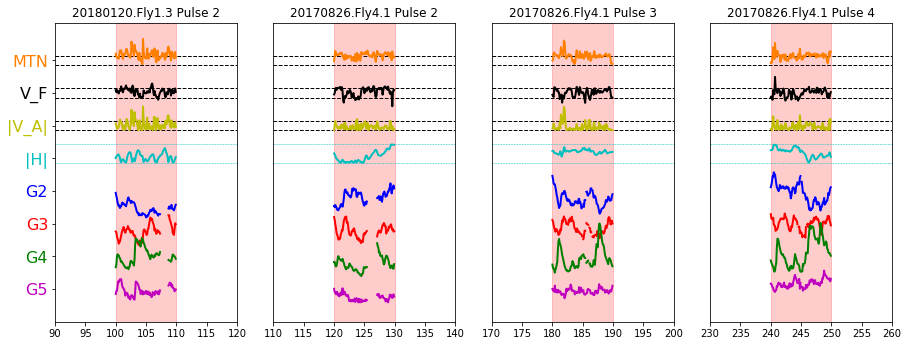

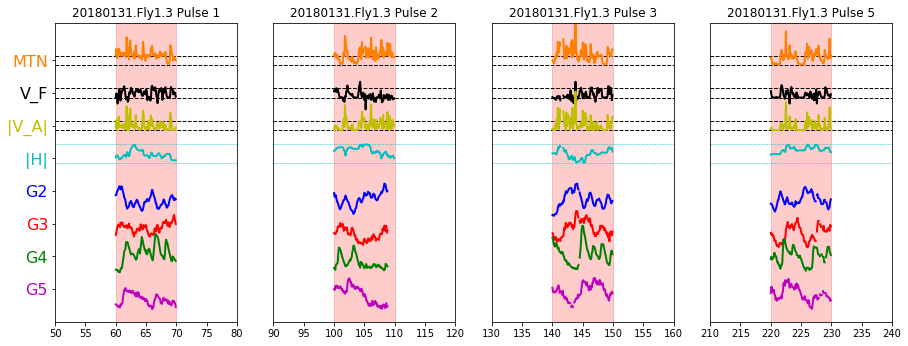

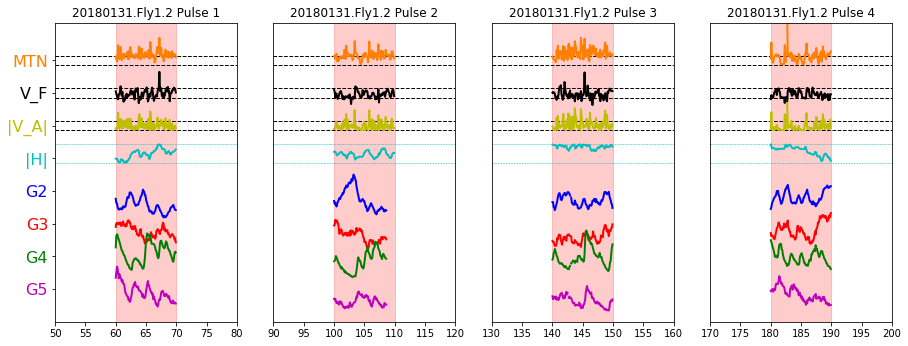

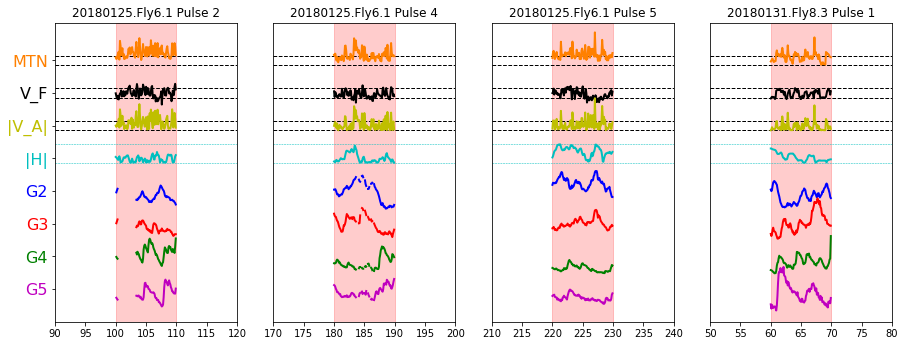

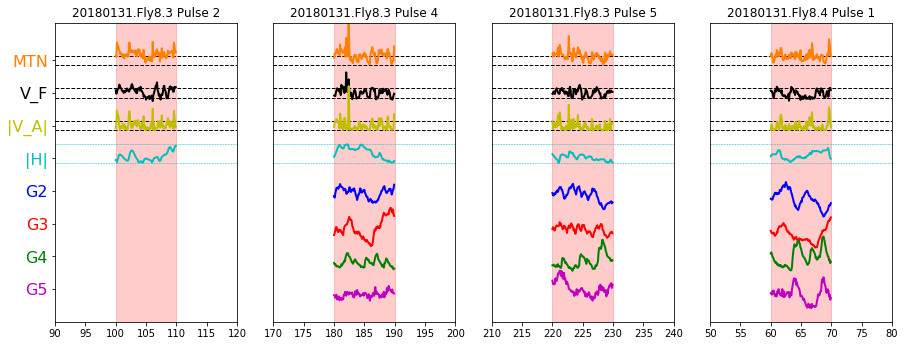

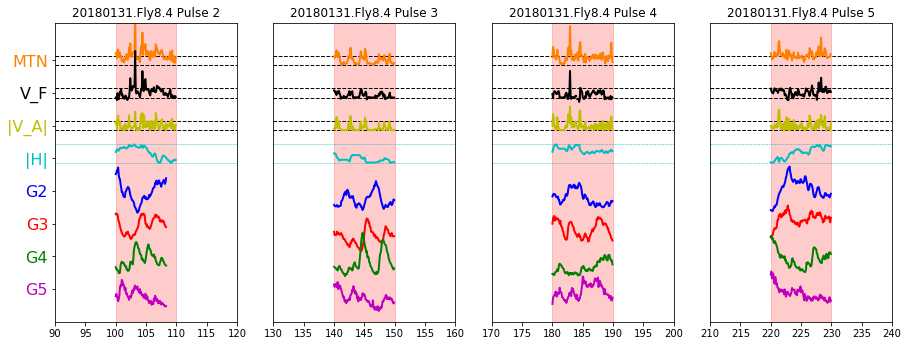

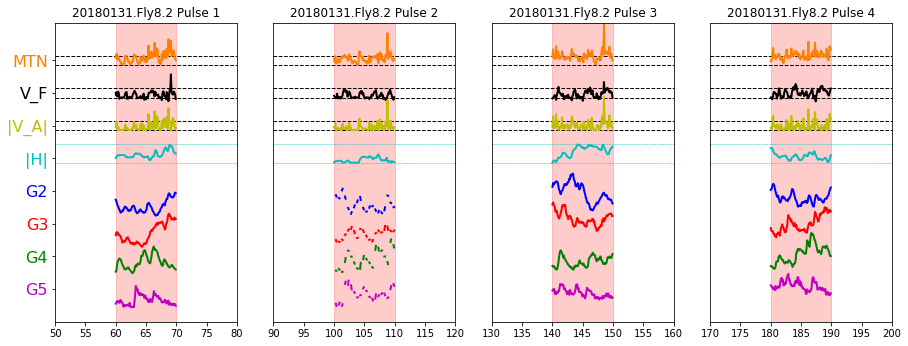

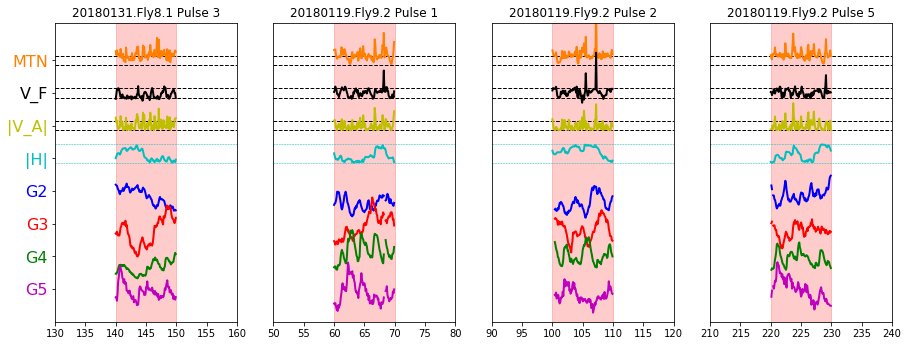

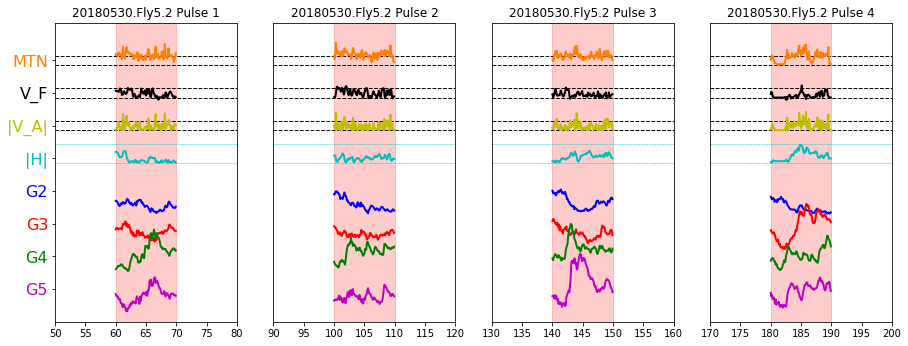

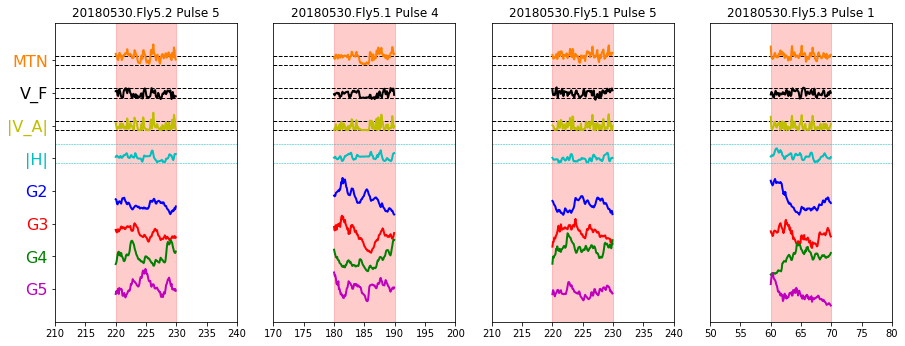

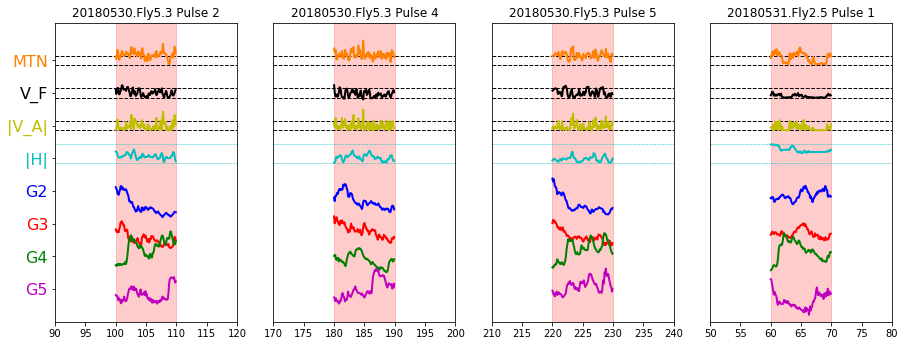

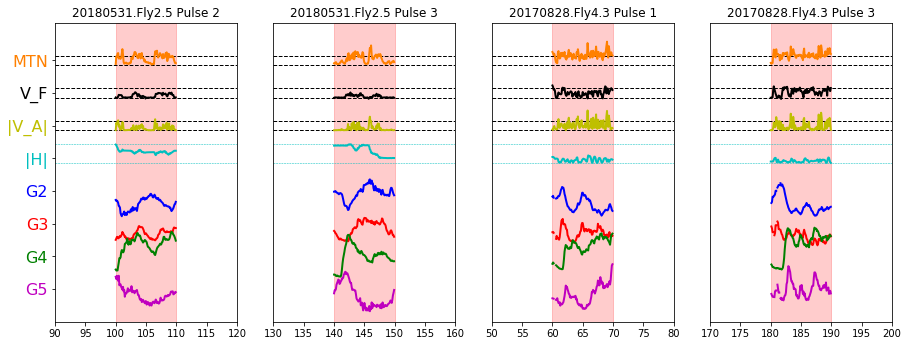

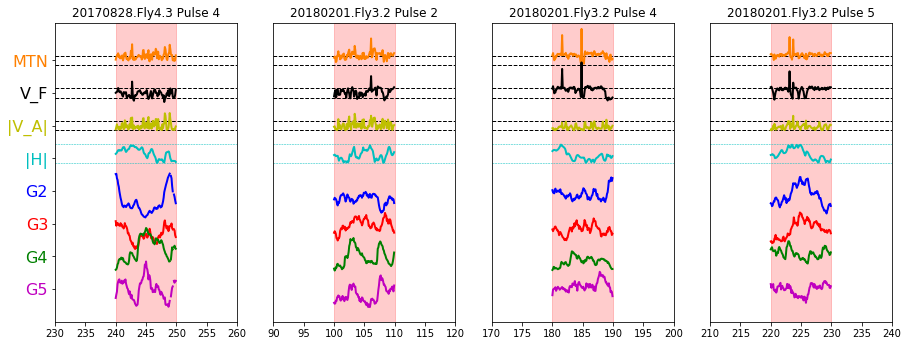

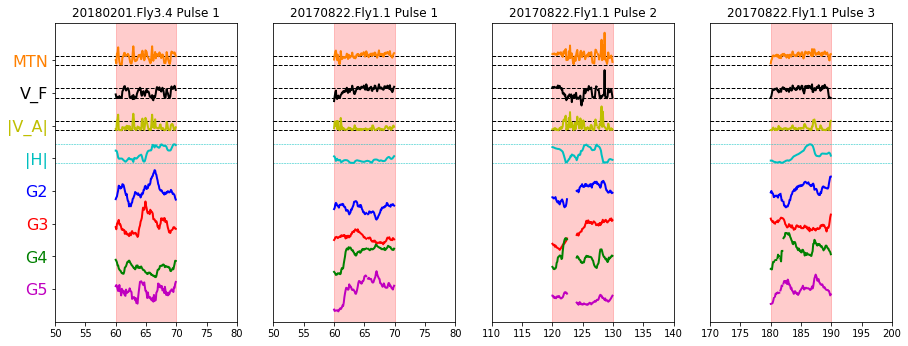

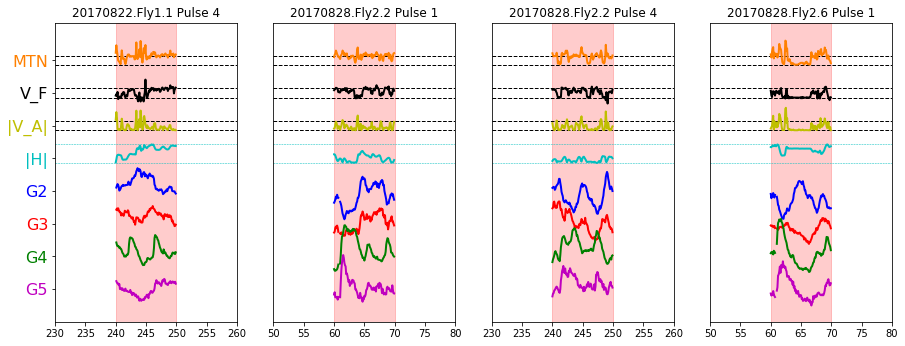

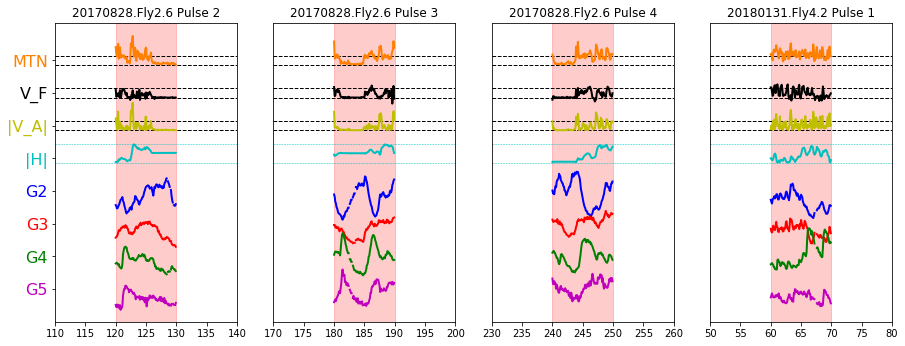

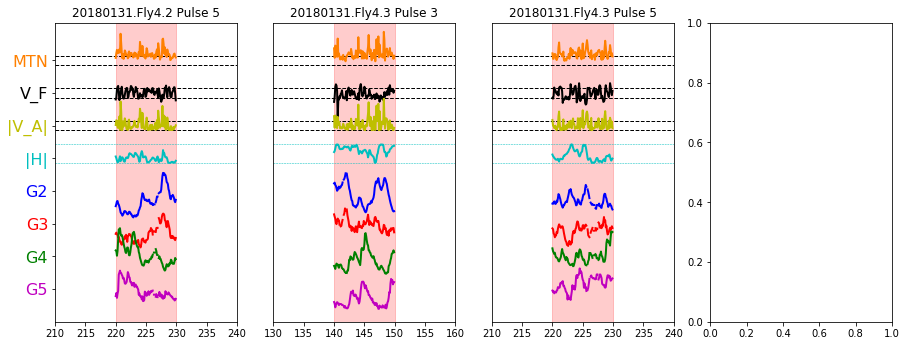

In [5]:
VS_PST = ['Motion', 'ForVel', 'AbsAngVel', 'AbsHeading', 'G2', 'G3', 'G4', 'G5']
LABELS = ['MTN', 'V_F', '|V_A|', '|H|', 'G2', 'G3', 'G4', 'G5']
PULSE_RANGE = [0, n_pulse]
N_COL = 4
FIG_SIZE = (15, 5.5)
Y_LIM = (-28, 4)

n_pulses = PULSE_RANGE[1] - PULSE_RANGE[0]
n_fig = int(np.ceil(n_pulses/N_COL))

p_ctr = 0

odor_trig_data = {v: [] for v in ['Time'] + VS_PST}

for fig_ctr in range(n_fig):
    fig, axs = plt.subplots(1, N_COL, figsize=FIG_SIZE)
    axs = axs.flatten()
    
    for p_id in range(p_ctr, min(p_ctr+N_COL, n_pulses)):
        
        ax = axs[p_id - p_ctr]
        trial = df_pulse.iloc[p_id]['Trial']
        pulse = df_pulse.iloc[p_id]['Pulse']
        start = df_pulse.iloc[p_id]['Start']
        stop = df_pulse.iloc[p_id]['Stop']
        t_mask = (start + T_WDW_PST[0] <= data_n[trial]['Time']) & (data_n[trial]['Time'] < start + T_WDW_PST[1])
        
        t = data_n[trial]['Time'][t_mask]
        
        odor_trig_data['Time'].append(np.array(t))
        
        # plot all vars
        offsets = []
        
        for v_ctr, v in enumerate(VS_PST):
            offset = -v_ctr*3.5
            v_vals = data_n[trial][v][t_mask].copy()
            
            if v in ['Motion', 'ForVel', 'AbsAngVel']:
                ax.axhline(offset-.5, lw=1, ls='--', alpha=1, color='k')
                ax.axhline(offset+.5, lw=1, ls='--', alpha=1, color='k')
                ax.plot(t, v_vals + offset-.5, color=COLORS[v], lw=2)
                
            elif v == 'AbsHeading':
                ax.axhline(offset-.5, lw=.5, ls='--', alpha=1, color=COLORS[v])
                ax.axhline(offset+1.5, lw=.5, ls='--', alpha=1, color=COLORS[v]) 
                ax.plot(t, v_vals/(np.pi/2) + offset-.5, color=COLORS[v], lw=2)
                
            else:
                ax.plot(t, v_vals + offset-.5, color=COLORS[v], lw=2)
            
            odor_trig_data[v].append(np.array(v_vals))
            
            offsets.append(offset)
        
        if CTL_T_OFFSET:
            c_odor = 'gray'
        else:
            c_odor = 'r'
            
        if EXPT in ['CL_360_LOWFLOW_ACV', 'CL_360_LOWFLOW_Fed']:
            ax.axvspan(start, stop, color=c_odor, alpha=0.2)
        elif EXPT == 'CL_180_HighFlow_ACV':
            ax.axvspan(start, stop, color=c_odor, alpha=0.2)
            
        ax.set_xlim(start - 10, start + 20)
        ax.set_ylim(Y_LIM)
        
        if p_ctr == p_id:
            ax.set_yticks(offsets)
            ax.set_yticklabels(LABELS)
            
            for y_tick, v in zip(ax.get_yticklabels(), ['Motion', 'ForVel', 'AbsAngVel', 'AbsHeading'] + vs):
                y_tick.set_color(COLORS[v])
                y_tick.set_fontsize(16)
        else:
            ax.yaxis.set_visible(False)
            
        ax.set_title('{} Pulse {}'.format(trial, pulse+1))
        
    p_ctr += N_COL

# Statistics

Odor-triggered ensembles

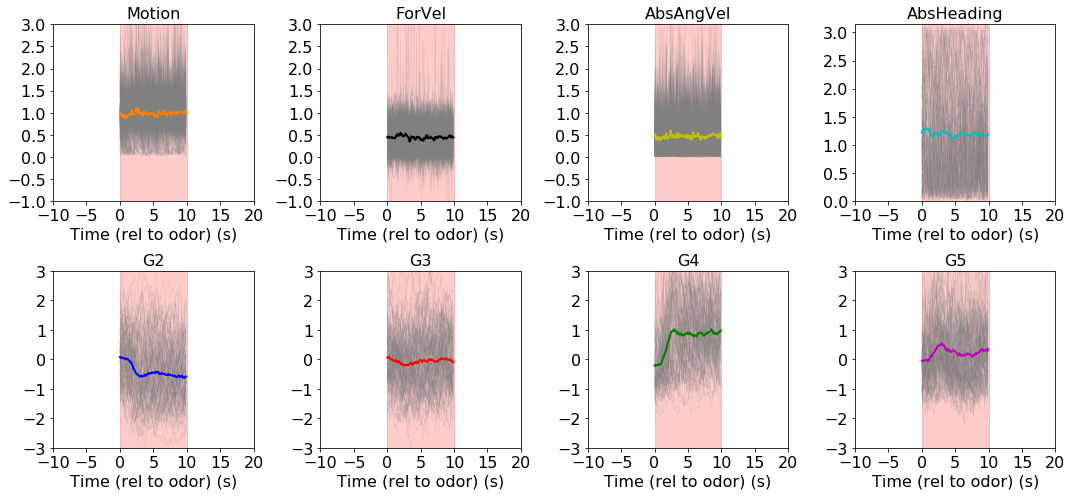

In [6]:
VS_PST = ['Motion', 'ForVel', 'AbsAngVel', 'AbsHeading', 'G2', 'G3', 'G4', 'G5']
Y_LIM = {
    'Motion': (-1, 3), 'ForVel': (-1, 3), 'AbsAngVel': (-1, 3), 'AbsHeading': (0, np.pi),
    'G2': (-3, 3), 'G3': (-3, 3), 'G4': (-3, 3), 'G5': (-3, 3)
}

odor_trig_means = {}

fig, axs = plt.subplots(2, 4, figsize=(15, 7), tight_layout=True)
axs = axs.flatten()

for v, ax in zip(VS_PST, axs):
    t = odor_trig_data['Time'][0]
    t -= t[0]
    t += T_WDW_PST[0]
    
    v_vals = np.array(odor_trig_data[v])
    
    ax.plot(t, v_vals.T, color='gray', lw=.5, alpha=.2)
    
    ax.plot(t, np.nanmean(v_vals, 0), color=COLORS[v], lw=2)
    odor_trig_means[v] = np.nanmean(v_vals, 0)
    
    if EXPT in ['CL_360_LOWFLOW_ACV', 'CL_360_LOWFLOW_Fed']:
        start = 0
        stop = 10
    elif EXPT == 'CL_180_HighFlow_ACV':
        start = 0
        stop = 60
    
    if CTL_T_OFFSET == 0:
        ax.axvspan(start, stop, color='r', alpha=0.2)
    else:
        ax.axvspan(start, stop, color='gray', alpha=0.2)
        
    ax.set_xlim(-10, 20)
    ax.set_ylim(Y_LIM[v])
    ax.set_xlabel('Time (rel to odor) (s)')
    ax.set_title(v)
    
for ax in axs:
    set_font_size(ax, 16)

Subtract odor-triggered means from responses

In [7]:
odor_trig_data_zeroed = {}

for v in VS_PST:
    odor_trig_data_zeroed[v] = odor_trig_data[v] - odor_trig_means[v]

Fit filters and assess correlations

In [38]:
#GX = 'G2'
#GX = 'G3'
#GX = 'G4'
GX = 'G5'

Fit filters

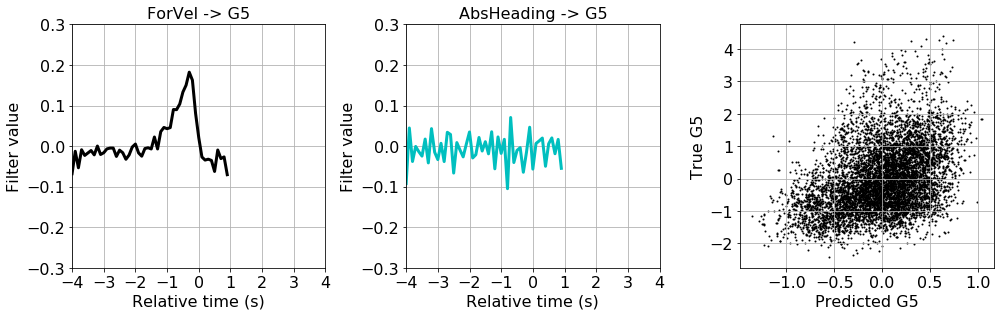

In [39]:
WDW_D = {'ForVel': (-40, 10), 'AbsHeading': (-40, 10)}
T_H = np.arange(WDW_D['ForVel'][0], WDW_D['ForVel'][1]) * DT

# make concatenated time-series to fit filters
nan_mat = np.nan * np.zeros((n_pulse, WDW_D['ForVel'][1] - WDW_D['ForVel'][0]))

forvel_vec = np.concatenate([odor_trig_data_zeroed['ForVel'], nan_mat], axis=1).flatten()
heading_vec = np.concatenate([odor_trig_data_zeroed['AbsHeading'], nan_mat], axis=1).flatten()
g_vec = np.concatenate([odor_trig_data_zeroed[GX], nan_mat], axis=1).flatten()

xs = {'ForVel': forvel_vec, 'AbsHeading': heading_vec}
y = g_vec
order = ['ForVel', 'AbsHeading']
method = 'built-in'
params = {'model': linear_model.LinearRegression}

hs, icpt, y_hat, r2 = fit_h(xs=xs, y=y, wdws_d=WDW_D, order=order, method=method, params=params)

fig, axs = plt.subplots(1, 3, figsize=(14, 4.5), tight_layout=True)
axs[0].plot(T_H, hs['ForVel'], lw=3, c='k')
axs[0].set_title(f'ForVel -> {GX}')

axs[1].plot(T_H, hs['AbsHeading'], lw=3, c='c')
axs[1].set_title(f'AbsHeading -> {GX}')

axs[2].scatter(y_hat, y, c='k', s=1)
axs[2].set_xlabel(f'Predicted {GX}')
axs[2].set_ylabel(f'True {GX}')

for ax in axs[:2]:
    ax.set_xlim(-4, 4)
    ax.set_ylim(-.3, .3)
    ax.set_xlabel('Relative time (s)')
    ax.set_ylabel('Filter value')
    
for ax in axs:
    set_font_size(ax, 16)
    ax.grid()
    
# create trial-by-trial y_hat (GX predicted from filters)
n_col = nan_mat.shape[1] + odor_trig_data_zeroed[GX][0].shape[0]
odor_trig_data_zeroed[f'{GX}_hat'] = y_hat.reshape(n_pulse, n_col)[:, :odor_trig_data_zeroed[GX][0].shape[0]]

odor_trig_data[f'{GX}_hat'] = odor_trig_data_zeroed[f'{GX}_hat'] + odor_trig_means[GX]

pd.DataFrame(columns=['TIME', 'FILTER_VALUE'], data={'TIME': T_H, 'FILTER_VALUE': hs['ForVel']}).to_csv(
    os.path.join(SAVE_DIR, f'{EXPT}_{LABEL}_ODOR_{GX}_FOR_VEL_TO_{GX}_FILTER.csv'), index=False)
pd.DataFrame(columns=['TIME', 'FILTER_VALUE'], data={'TIME': T_H, 'FILTER_VALUE': hs['AbsHeading']}).to_csv(
    os.path.join(SAVE_DIR, f'{EXPT}_{LABEL}_ODOR_{GX}_ABS_HEADING_TO_{GX}_FILTER.csv'), index=False)

In [40]:
# make predictor matrix and reshape params
predictor_mat = make_extended_predictor_matrix(vs=xs, windows=WDW_D, order=order)
reshape = {'shape': (n_pulse, n_col), 'cut': odor_trig_data_zeroed[GX][0].shape[0]}

# save filters and means
h_vec_gx = np.concatenate([hs[k] for k in order])
icpt_gx = icpt
means_gx = odor_trig_means[GX]

np.save(f'10A_filters_{EXPT}_{GX}_{LABEL}.npy', np.array([{'h_vec': h_vec_gx, 'icpt': icpt_gx, 'means': means_gx}]))

Make scatter plots of time-averaged correlations

In [41]:
m_pre = (-10 <= t) & (t < 0)
m_dur = (0 <= t) & (t < 10)

### Base behav vs DAN activity before odor (no delta)

In [42]:
if LABEL == 'BEFORE':

    forvel_pre = np.array(
        [np.nanmean(for_vel[m_pre]) for for_vel in odor_trig_data['ForVel']])
    head_pre = np.array(
        [np.nanmean(head[m_pre]) for head in odor_trig_data['AbsHeading']])
    g_pre = np.array(
        [np.nanmean(g[m_pre]) for g in odor_trig_data[GX]])
    g_hat_pre = np.array(
        [np.nanmean(g_hat[m_pre]) for g_hat in odor_trig_data[f'{GX}_hat']])

    fig, axs = plt.subplots(1, 4, figsize=(15, 4), tight_layout=True)

    # G true vs forvel
    axs[0].scatter(forvel_pre, g_pre, c='k', s=15)
    x_ln, y_ln, (slp, icpt, r, p, stderr) = get_line(forvel_pre, g_pre)
    axs[0].plot(x_ln, y_ln, c='r', lw=2)

    axs[0].set_xlabel(f'ForVel pre-odor')
    axs[0].set_ylabel(f'{GX} pre-odor True')
    axs[0].set_title(f'Slope = {slp:.3f}\nR = {r:.3f}, P = {p:.3f}')


    # G true vs heading
    axs[1].scatter(head_pre, g_pre, c='k', s=15)
    x_ln, y_ln, (slp, icpt, r, p, stderr) = get_line(head_pre, g_pre)
    axs[1].plot(x_ln, y_ln, c='r', lw=2)

    axs[1].set_xlabel(f'AbsHeading pre-odor')
    axs[1].set_ylabel(f'{GX} pre-odor True')
    axs[1].set_title(f'Slope = {slp:.3f}\nR = {r:.3f}, P = {p:.3f}')


    # G predicted vs forvel
    axs[2].scatter(forvel_pre, g_hat_pre, c='k', s=15)
    x_ln, y_ln, (slp, icpt, r, p, stderr) = get_line(forvel_pre, g_hat_pre)
    axs[2].plot(x_ln, y_ln, c='r', lw=2)

    axs[2].set_xlabel(f'ForVel pre-odor')
    axs[2].set_ylabel(f'{GX} pre-odor Predicted')
    axs[2].set_title(f'Slope = {slp:.3f}\nR = {r:.3f}, P = {p:.3f}')


    # G predicted vs heading
    axs[3].scatter(head_pre, g_hat_pre, c='k', s=15)
    x_ln, y_ln, (slp, icpt, r, p, stderr) = get_line(head_pre, g_hat_pre)
    axs[3].plot(x_ln, y_ln, c='r', lw=2)

    axs[3].set_xlabel(f'AbsHeading pre-odor')
    axs[3].set_ylabel(f'{GX} pre-odor Predicted')
    axs[3].set_title(f'Slope = {slp:.3f}\nR = {r:.3f}, P = {p:.3f}')


    for ax in axs:
        ax.set_ylim(-2, 3)
        set_font_size(ax, 16)

    print(f'{EXPT} filters applied to {EXPT} pre-odor data.')
    
    # panel 1: BEFORE ODOR TRUE GX vs FOR_VEL
    pd.DataFrame(columns=['FOR_VEL', GX], data={'FOR_VEL': forvel_pre, GX: g_pre}).to_csv(
        os.path.join(SAVE_DIR, f'{EXPT}_{LABEL}_ODOR_TRUE_{GX}_VS_FOR_VEL_SCATTER.csv'), index=False)
    pd.DataFrame(columns=['SLOPE', 'R', 'P'], data={
        'SLOPE': [get_line(forvel_pre, g_pre)[2][0]],
        'R': [get_line(forvel_pre, g_pre)[2][2]],
        'P': [get_line(forvel_pre, g_pre)[2][3]]}).to_csv(
        os.path.join(SAVE_DIR, f'{EXPT}_{LABEL}_ODOR_TRUE_{GX}_VS_FOR_VEL_SCATTER_SLP_R_P.csv'), index=False)
    
    # panel 2: BEFORE ODOR TRUE GX vs ABS_HEADING
    pd.DataFrame(columns=['ABS_HEADING', GX], data={'ABS_HEADING': head_pre, GX: g_pre}).to_csv(
        os.path.join(SAVE_DIR, f'{EXPT}_{LABEL}_ODOR_TRUE_{GX}_VS_ABS_HEADING_SCATTER.csv'), index=False)
    pd.DataFrame(columns=['SLOPE', 'R', 'P'], data={
        'SLOPE': [get_line(head_pre, g_pre)[2][0]],
        'R': [get_line(head_pre, g_pre)[2][2]],
        'P': [get_line(head_pre, g_pre)[2][3]]}).to_csv(
        os.path.join(SAVE_DIR, f'{EXPT}_{LABEL}_ODOR_TRUE_{GX}_VS_ABS_HEADING_SCATTER_SLP_R_P.csv'), index=False)
    
    # panel 3: BEFORE ODOR PREDICTED GX vs FOR_VEL
    pd.DataFrame(columns=['FOR_VEL', GX], data={'FOR_VEL': forvel_pre, GX: g_hat_pre}).to_csv(
        os.path.join(SAVE_DIR, f'{EXPT}_{LABEL}_ODOR_PREDICTED_{GX}_VS_FOR_VEL_SCATTER.csv'), index=False)
    pd.DataFrame(columns=['SLOPE', 'R', 'P'], data={
        'SLOPE': [get_line(forvel_pre, g_hat_pre)[2][0]],
        'R': [get_line(forvel_pre, g_hat_pre)[2][2]],
        'P': [get_line(forvel_pre, g_hat_pre)[2][3]]}).to_csv(
        os.path.join(SAVE_DIR, f'{EXPT}_{LABEL}_ODOR_PREDICTED_{GX}_VS_FOR_VEL_SCATTER_SLP_R_P.csv'), index=False)
    
    # panel 4: BEFORE ODOR PREDICTED GX vs ABS_HEADING
    pd.DataFrame(columns=['ABS_HEADING', GX], data={'ABS_HEADING': head_pre, GX: g_hat_pre}).to_csv(
        os.path.join(SAVE_DIR, f'{EXPT}_{LABEL}_ODOR_PREDICTED_{GX}_VS_ABS_HEADING_SCATTER.csv'), index=False)
    pd.DataFrame(columns=['SLOPE', 'R', 'P'], data={
        'SLOPE': [get_line(head_pre, g_hat_pre)[2][0]],
        'R': [get_line(head_pre, g_hat_pre)[2][2]],
        'P': [get_line(head_pre, g_hat_pre)[2][3]]}).to_csv(
        os.path.join(SAVE_DIR, f'{EXPT}_{LABEL}_ODOR_PREDICTED_{GX}_VS_ABS_HEADING_SCATTER_SLP_R_P.csv'), index=False)

### Base behav vs DAN activity during odor (no delta)

CL_360_LOWFLOW_ACV filters applied to CL_360_LOWFLOW_ACV during-odor data.


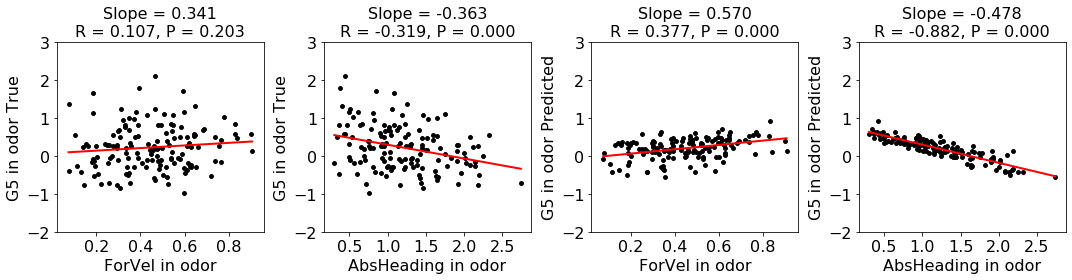

In [43]:
if LABEL == 'DURING':

    forvel_dur = np.array(
        [np.nanmean(for_vel[m_dur]) for for_vel in odor_trig_data['ForVel']])
    head_dur = np.array(
        [np.nanmean(head[m_dur]) for head in odor_trig_data['AbsHeading']])
    g_dur = np.array(
        [np.nanmean(g[m_dur]) for g in odor_trig_data[GX]])
    g_hat_dur = np.array(
        [np.nanmean(g_hat[m_dur]) for g_hat in odor_trig_data[f'{GX}_hat']])

    fig, axs = plt.subplots(1, 4, figsize=(15, 4), tight_layout=True)

    # G true vs forvel
    axs[0].scatter(forvel_dur, g_dur, c='k', s=15)
    x_ln, y_ln, (slp, icpt, r, p, stderr) = get_line(forvel_dur, g_dur)
    axs[0].plot(x_ln, y_ln, c='r', lw=2)

    axs[0].set_xlabel(f'ForVel in odor')
    axs[0].set_ylabel(f'{GX} in odor True')
    axs[0].set_title(f'Slope = {slp:.3f}\nR = {r:.3f}, P = {p:.3f}')


    # G true vs heading
    axs[1].scatter(head_dur, g_dur, c='k', s=15)
    x_ln, y_ln, (slp, icpt, r, p, stderr) = get_line(head_dur, g_dur)
    axs[1].plot(x_ln, y_ln, c='r', lw=2)

    axs[1].set_xlabel(f'AbsHeading in odor')
    axs[1].set_ylabel(f'{GX} in odor True')
    axs[1].set_title(f'Slope = {slp:.3f}\nR = {r:.3f}, P = {p:.3f}')


    # G predicted vs forvel
    axs[2].scatter(forvel_dur, g_hat_dur, c='k', s=15)
    x_ln, y_ln, (slp, icpt, r, p, stderr) = get_line(forvel_dur, g_hat_dur)
    axs[2].plot(x_ln, y_ln, c='r', lw=2)

    axs[2].set_xlabel(f'ForVel in odor')
    axs[2].set_ylabel(f'{GX} in odor Predicted')
    axs[2].set_title(f'Slope = {slp:.3f}\nR = {r:.3f}, P = {p:.3f}')


    # G predicted vs heading
    axs[3].scatter(head_dur, g_hat_dur, c='k', s=15)
    x_ln, y_ln, (slp, icpt, r, p, stderr) = get_line(head_dur, g_hat_dur)
    axs[3].plot(x_ln, y_ln, c='r', lw=2)

    axs[3].set_xlabel(f'AbsHeading in odor')
    axs[3].set_ylabel(f'{GX} in odor Predicted')
    axs[3].set_title(f'Slope = {slp:.3f}\nR = {r:.3f}, P = {p:.3f}')


    for ax in axs:
        ax.set_ylim(-2, 3)
        set_font_size(ax, 16)

    print(f'{EXPT} filters applied to {EXPT} during-odor data.')
    
    # panel 1: DURING ODOR TRUE GX vs FOR_VEL
    pd.DataFrame(columns=['FOR_VEL', GX], data={'FOR_VEL': forvel_dur, GX: g_dur}).to_csv(
        os.path.join(SAVE_DIR, f'{EXPT}_{LABEL}_ODOR_TRUE_{GX}_VS_FOR_VEL_SCATTER.csv'), index=False)
    pd.DataFrame(columns=['SLOPE', 'R', 'P'], data={
        'SLOPE': [get_line(forvel_dur, g_dur)[2][0]],
        'R': [get_line(forvel_dur, g_dur)[2][2]],
        'P': [get_line(forvel_dur, g_dur)[2][3]]}).to_csv(
        os.path.join(SAVE_DIR, f'{EXPT}_{LABEL}_ODOR_TRUE_{GX}_VS_FOR_VEL_SCATTER_SLP_R_P.csv'), index=False)
    
    # panel 2: DURING ODOR TRUE GX vs ABS_HEADING
    pd.DataFrame(columns=['ABS_HEADING', GX], data={'ABS_HEADING': head_dur, GX: g_dur}).to_csv(
        os.path.join(SAVE_DIR, f'{EXPT}_{LABEL}_ODOR_TRUE_{GX}_VS_ABS_HEADING_SCATTER.csv'), index=False)
    pd.DataFrame(columns=['SLOPE', 'R', 'P'], data={
        'SLOPE': [get_line(head_dur, g_dur)[2][0]],
        'R': [get_line(head_dur, g_dur)[2][2]],
        'P': [get_line(head_dur, g_dur)[2][3]]}).to_csv(
        os.path.join(SAVE_DIR, f'{EXPT}_{LABEL}_ODOR_TRUE_{GX}_VS_ABS_HEADING_SCATTER_SLP_R_P.csv'), index=False)
    
    # panel 3: DURING ODOR PREDICTED GX vs FOR_VEL
    pd.DataFrame(columns=['FOR_VEL', GX], data={'FOR_VEL': forvel_dur, GX: g_hat_dur}).to_csv(
        os.path.join(SAVE_DIR, f'{EXPT}_{LABEL}_ODOR_PREDICTED_{GX}_VS_FOR_VEL_SCATTER.csv'), index=False)
    pd.DataFrame(columns=['SLOPE', 'R', 'P'], data={
        'SLOPE': [get_line(forvel_dur, g_hat_dur)[2][0]],
        'R': [get_line(forvel_dur, g_hat_dur)[2][2]],
        'P': [get_line(forvel_dur, g_hat_dur)[2][3]]}).to_csv(
        os.path.join(SAVE_DIR, f'{EXPT}_{LABEL}_ODOR_PREDICTED_{GX}_VS_FOR_VEL_SCATTER_SLP_R_P.csv'), index=False)
    
    # panel 4: DURING ODOR PREDICTED GX vs ABS_HEADING
    pd.DataFrame(columns=['ABS_HEADING', GX], data={'ABS_HEADING': head_dur, GX: g_hat_dur}).to_csv(
        os.path.join(SAVE_DIR, f'{EXPT}_{LABEL}_ODOR_PREDICTED_{GX}_VS_ABS_HEADING_SCATTER.csv'), index=False)
    pd.DataFrame(columns=['SLOPE', 'R', 'P'], data={
        'SLOPE': [get_line(head_dur, g_hat_dur)[2][0]],
        'R': [get_line(head_dur, g_hat_dur)[2][2]],
        'P': [get_line(head_dur, g_hat_dur)[2][3]]}).to_csv(
        os.path.join(SAVE_DIR, f'{EXPT}_{LABEL}_ODOR_PREDICTED_{GX}_VS_ABS_HEADING_SCATTER_SLP_R_P.csv'), index=False)

# Swapped filters

In [44]:
if EXPT == 'CL_360_LOWFLOW_ACV':
    #EXPT_FILT = 'CL_360_LOWFLOW_ACV'
    EXPT_FILT = 'CL_180_HighFlow_ACV'
elif EXPT == 'CL_180_HighFlow_ACV':
    #EXPT_FILT = 'CL_180_HighFlow_ACV'
    EXPT_FILT = 'CL_360_LOWFLOW_ACV'

In [45]:
# load filters
h_data = np.load(f'10A_filters_{EXPT_FILT}_{GX}_{LABEL}.npy', allow_pickle=True)[0]
h_vec_gx = h_data['h_vec']
icpt_gx = h_data['icpt']
means_gx = h_data['means']

# reconstruct odor triggered data
test_y_hat = predictor_mat @ h_vec_gx + icpt_gx
test_odor_trig_data_zeroed_gx = test_y_hat.reshape(*reshape['shape'])[:, :reshape['cut']]
test_odor_trig_data_gx = test_odor_trig_data_zeroed_gx + means_gx

### Base behav vs DAN activity before odor (no delta)

In [46]:
if LABEL == 'BEFORE':

    forvel_pre = np.array(
        [np.nanmean(for_vel[m_pre]) for for_vel in odor_trig_data['ForVel']])
    head_pre = np.array(
        [np.nanmean(head[m_pre]) for head in odor_trig_data['AbsHeading']])
    g_pre = np.array(
        [np.nanmean(g[m_pre]) for g in odor_trig_data[GX]])
    g_hat_pre = np.array(
        [np.nanmean(g_hat[m_pre]) for g_hat in test_odor_trig_data_gx])

    fig, axs = plt.subplots(1, 4, figsize=(15, 4), tight_layout=True)

    # G true vs forvel
    axs[0].scatter(forvel_pre, g_pre, c='k', s=15)
    x_ln, y_ln, (slp, icpt, r, p, stderr) = get_line(forvel_pre, g_pre)
    axs[0].plot(x_ln, y_ln, c='r', lw=2)

    axs[0].set_xlabel(f'ForVel pre-odor')
    axs[0].set_ylabel(f'{GX} pre-odor True')
    axs[0].set_title(f'Slope = {slp:.3f}\nR = {r:.3f}, P = {p:.3f}')


    # G true vs heading
    axs[1].scatter(head_pre, g_pre, c='k', s=15)
    x_ln, y_ln, (slp, icpt, r, p, stderr) = get_line(head_pre, g_pre)
    axs[1].plot(x_ln, y_ln, c='r', lw=2)

    axs[1].set_xlabel(f'AbsHeading pre-odor')
    axs[1].set_ylabel(f'{GX} pre-odor True')
    axs[1].set_title(f'Slope = {slp:.3f}\nR = {r:.3f}, P = {p:.3f}')


    # G predicted vs forvel
    axs[2].scatter(forvel_pre, g_hat_pre, c='k', s=15)
    x_ln, y_ln, (slp, icpt, r, p, stderr) = get_line(forvel_pre, g_hat_pre)
    axs[2].plot(x_ln, y_ln, c='r', lw=2)

    axs[2].set_xlabel(f'ForVel pre-odor')
    axs[2].set_ylabel(f'{GX} pre-odor Predicted')
    axs[2].set_title(f'Slope = {slp:.3f}\nR = {r:.3f}, P = {p:.3f}')


    # G predicted vs heading
    axs[3].scatter(head_pre, g_hat_pre, c='k', s=15)
    x_ln, y_ln, (slp, icpt, r, p, stderr) = get_line(head_pre, g_hat_pre)
    axs[3].plot(x_ln, y_ln, c='r', lw=2)

    axs[3].set_xlabel(f'AbsHeading pre-odor')
    axs[3].set_ylabel(f'{GX} pre-odor Predicted')
    axs[3].set_title(f'Slope = {slp:.3f}\nR = {r:.3f}, P = {p:.3f}')


    for ax in axs:
        ax.set_ylim(-2, 3)
        set_font_size(ax, 16)

    print(f'{EXPT_FILT} filters applied to {EXPT} pre-odor data.')
    
    # panel 3: BEFORE ODOR PREDICTED GX vs FOR_VEL
    pd.DataFrame(columns=['FOR_VEL', GX], data={'FOR_VEL': forvel_pre, GX: g_hat_pre}).to_csv(
        os.path.join(SAVE_DIR, f'{EXPT_FILT}_{LABEL}_ODOR_FILTERS_ON_{EXPT}_BEHAV_DATA_{GX}_VS_FOR_VEL_SCATTER.csv'), index=False)
    pd.DataFrame(columns=['SLOPE', 'R', 'P'], data={
        'SLOPE': [get_line(forvel_pre, g_hat_pre)[2][0]],
        'R': [get_line(forvel_pre, g_hat_pre)[2][2]],
        'P': [get_line(forvel_pre, g_hat_pre)[2][3]]}).to_csv(
        os.path.join(SAVE_DIR, f'{EXPT_FILT}_{LABEL}_ODOR_FILTERS_ON_{EXPT}_BEHAV_DATA_{GX}_VS_FOR_VEL_SCATTER_SLP_R_P.csv'), index=False)

    # panel 4: BEFORE ODOR PREDICTED GX vs ABS_HEADING
    pd.DataFrame(columns=['ABS_HEADING', GX], data={'ABS_HEADING': head_pre, GX: g_hat_pre}).to_csv(
        os.path.join(SAVE_DIR, f'{EXPT_FILT}_{LABEL}_ODOR_FILTERS_ON_{EXPT}_BEHAV_DATA_{GX}_VS_ABS_HEADING_SCATTER.csv'), index=False)
    pd.DataFrame(columns=['SLOPE', 'R', 'P'], data={
        'SLOPE': [get_line(head_pre, g_hat_pre)[2][0]],
        'R': [get_line(head_pre, g_hat_pre)[2][2]],
        'P': [get_line(head_pre, g_hat_pre)[2][3]]}).to_csv(
        os.path.join(SAVE_DIR, f'{EXPT_FILT}_{LABEL}_ODOR_FILTERS_ON_{EXPT}_BEHAV_DATA_{GX}_VS_ABS_HEADING_SCATTER_SLP_R_P.csv'), index=False)

### Base behav vs DAN activity during odor (no delta)

CL_180_HighFlow_ACV filters applied to CL_360_LOWFLOW_ACV during-odor data.


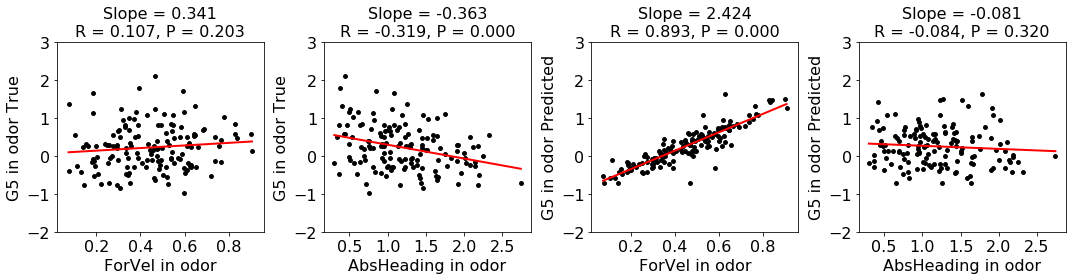

In [47]:
if LABEL == 'DURING':

    forvel_dur = np.array(
        [np.nanmean(for_vel[m_dur]) for for_vel in odor_trig_data['ForVel']])
    head_dur = np.array(
        [np.nanmean(head[m_dur]) for head in odor_trig_data['AbsHeading']])
    g_dur = np.array(
        [np.nanmean(g[m_dur]) for g in odor_trig_data[GX]])
    g_hat_dur = np.array(
        [np.nanmean(g_hat[m_dur]) for g_hat in test_odor_trig_data_gx])

    fig, axs = plt.subplots(1, 4, figsize=(15, 4), tight_layout=True)

    # G true vs forvel
    axs[0].scatter(forvel_dur, g_dur, c='k', s=15)
    x_ln, y_ln, (slp, icpt, r, p, stderr) = get_line(forvel_dur, g_dur)
    axs[0].plot(x_ln, y_ln, c='r', lw=2)

    axs[0].set_xlabel(f'ForVel in odor')
    axs[0].set_ylabel(f'{GX} in odor True')
    axs[0].set_title(f'Slope = {slp:.3f}\nR = {r:.3f}, P = {p:.3f}')


    # G true vs heading
    axs[1].scatter(head_dur, g_dur, c='k', s=15)
    x_ln, y_ln, (slp, icpt, r, p, stderr) = get_line(head_dur, g_dur)
    axs[1].plot(x_ln, y_ln, c='r', lw=2)

    axs[1].set_xlabel(f'AbsHeading in odor')
    axs[1].set_ylabel(f'{GX} in odor True')
    axs[1].set_title(f'Slope = {slp:.3f}\nR = {r:.3f}, P = {p:.3f}')


    # G predicted vs forvel
    axs[2].scatter(forvel_dur, g_hat_dur, c='k', s=15)
    x_ln, y_ln, (slp, icpt, r, p, stderr) = get_line(forvel_dur, g_hat_dur)
    axs[2].plot(x_ln, y_ln, c='r', lw=2)

    axs[2].set_xlabel(f'ForVel in odor')
    axs[2].set_ylabel(f'{GX} in odor Predicted')
    axs[2].set_title(f'Slope = {slp:.3f}\nR = {r:.3f}, P = {p:.3f}')


    # G predicted vs heading
    axs[3].scatter(head_dur, g_hat_dur, c='k', s=15)
    x_ln, y_ln, (slp, icpt, r, p, stderr) = get_line(head_dur, g_hat_dur)
    axs[3].plot(x_ln, y_ln, c='r', lw=2)

    axs[3].set_xlabel(f'AbsHeading in odor')
    axs[3].set_ylabel(f'{GX} in odor Predicted')
    axs[3].set_title(f'Slope = {slp:.3f}\nR = {r:.3f}, P = {p:.3f}')


    for ax in axs:
        ax.set_ylim(-2, 3)
        set_font_size(ax, 16)

    print(f'{EXPT_FILT} filters applied to {EXPT} during-odor data.')

    # panel 3: DURING ODOR PREDICTED GX vs FOR_VEL
    pd.DataFrame(columns=['FOR_VEL', GX], data={'FOR_VEL': forvel_dur, GX: g_hat_dur}).to_csv(
        os.path.join(SAVE_DIR, f'{EXPT_FILT}_{LABEL}_ODOR_FILTERS_ON_{EXPT}_BEHAV_DATA_{GX}_VS_FOR_VEL_SCATTER.csv'), index=False)
    pd.DataFrame(columns=['SLOPE', 'R', 'P'], data={
        'SLOPE': [get_line(forvel_dur, g_hat_dur)[2][0]],
        'R': [get_line(forvel_dur, g_hat_dur)[2][2]],
        'P': [get_line(forvel_dur, g_hat_dur)[2][3]]}).to_csv(
        os.path.join(SAVE_DIR, f'{EXPT_FILT}_{LABEL}_ODOR_FILTERS_ON_{EXPT}_BEHAV_DATA_{GX}_VS_FOR_VEL_SCATTER_SLP_R_P.csv'), index=False)
    
    # panel 4: DURING ODOR PREDICTED GX vs ABS_HEADING
    pd.DataFrame(columns=['ABS_HEADING', GX], data={'ABS_HEADING': head_dur, GX: g_hat_dur}).to_csv(
        os.path.join(SAVE_DIR, f'{EXPT_FILT}_{LABEL}_ODOR_FILTERS_ON_{EXPT}_BEHAV_DATA_{GX}_VS_ABS_HEADING_SCATTER.csv'), index=False)
    pd.DataFrame(columns=['SLOPE', 'R', 'P'], data={
        'SLOPE': [get_line(head_dur, g_hat_dur)[2][0]],
        'R': [get_line(head_dur, g_hat_dur)[2][2]],
        'P': [get_line(head_dur, g_hat_dur)[2][3]]}).to_csv(
        os.path.join(SAVE_DIR, f'{EXPT_FILT}_{LABEL}_ODOR_FILTERS_ON_{EXPT}_BEHAV_DATA_{GX}_VS_ABS_HEADING_SCATTER_SLP_R_P.csv'), index=False)